# Degeneracy and robustness

In [5]:
#@title Run the following to initialize lab environment.

!pip install ipympl ipywidgets stg-net -q

import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display

# Colab setting for widget
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

# modeling library
from stg_net.neuron import LIF
from stg_net.input import Poisson_generator, Gaussian_generator, Current_injector
from stg_net.conn import Simulator
from stg_net.helper import plot_volt_trace

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}
plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

# Widget interaction
%matplotlib widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.9 MB/s eta 0:00:00


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

## Redundancy and robustness (30min)

## Constructing the pyloric circuit (30min)
In the following code we will realize the pyloric rhythm generator using our simplified neurons.

<div style="text-align: center;">
    <img src="https://github.com/weirdoglh/ComBioNetwork/blob/main/book/Lab1/pyloric-circuit.PNG?raw=true" alt="Pyloric colour" width="300"/>
    <img src="https://github.com/weirdoglh/ComBioNetwork/blob/main/book/Lab1/pyloric-colour.png?raw=true" alt="Pyloric colour" width="700"/>
</div>

(Hooper and Marder, 1987)
(Kispersky et al., 2011)

In the table below *columns* are **PRESYNAPTIC** neurons and *rows* are **POSTSYNAPTIC** neurons

In [6]:
#@title Run the following to start pyloric circuit simulation { vertical-output: true }
# experiment setting
T, dt = 5e2, 0.1        # simulation period(ms), step size(ms)

tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron,
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron,
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron,
                 'delayed_neuron': delayed_neuron, 'my_neuron': tonic_neuron}

# AB-LP -0.79
# AB-PY -0.07
# VD-AB -0.04

# neurons
nrn_labels = ['AB', 'VD', 'IC', 'PD', 'LP', 'PY']
N = len(nrn_labels)
nrn_types = ['bursting_neuron']*N
rt = 50.
wts = [1.0]*N

# widget
grid = widgets.GridspecLayout(N+1, N+1)
signs = np.array([  [0 , 1 , 0 , 1 , 0 , 0],
                    [-1, 0 , -1, 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [1 , 1 , 0 , 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [-1, -1, 0 , -1, -1, 0]])
wsize = '200px'
for i, label in enumerate(nrn_labels):
    grid[0, i+1] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
for i, label in enumerate(nrn_labels):
    grid[i+1, 0] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
grid[0,0] = widgets.Text(value='J', disabled=True, layout=widgets.Layout(width=wsize))
for i in range(N):
    for j in range(N):
        if signs[i,j] != 0:
            grid[i+1,j+1] = widgets.FloatSlider(min=-10.0, max=-0.0, step=0.01, layout=widgets.Layout(width=wsize))
        else:
            grid[i+1,j+1] = widgets.Text(value='0', disabled=True, layout=widgets.Layout(width=wsize))

con_bars = {}
for i, tar in enumerate(nrn_labels):
    for j, src in enumerate(nrn_labels):
        con_bars['J_%s_%s'%(tar, src)] = grid[i+1,j+1]
con_pyloric = None

# updating parameters
indices = [0, 1, 2, 5, 4, 3]
nrn_ticks = [nrn_labels[i] for i in indices] + ['Recorded lvn']
def update_pyloric(**con_dict):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn, label, ntype in zip(nrns, nrn_labels, nrn_types):
        nrn.name = label
        nrn.update(neuron_params[ntype])

    # background noise
    noises = [Current_injector(sim=h, rate=rt, start=int(T/dt*0.1), end=int(T/dt*0.9)) for _ in range(N)]
    for noise, nrn, wt in zip(noises, nrns, wts):
        nrn.connect(noise, {'ctype':'Static', 'weight':wt})

    # recurrent connections
    tps = [['Static']*N]*N
    con = np.reshape(np.array(list(con_dict.values()), dtype=float), (N,N))
    global con_pyloric
    con_pyloric = con_dict
    for i in range(N):
        for j in range(N):
            if signs[i][j] > 0:
                tps[i][j] = 'Gap'
            else:
                tps[i][j] = 'Static'
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualization
    cs = ['k', 'k', 'k', 'b', 'green', 'purple']
    plt.clf()
    plt.title('pyloric')
    for nrn, c, l in zip(nrns, cs, indices):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    for idx in [5, 4, 3]:
        plt.eventplot(nrns[idx].spikes['times'], lineoffsets=2*N, colors=cs[idx])
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N+1)*2), nrn_ticks)
    plt.xlim([0., T])
    plt.tight_layout()

try:
  plt.figure(fig_pyloric)
  plt.clf()
except:
  print("Init figure")

fig_pyloric = plt.figure(figsize=(8,8))
widget_pyloric = widgets.interactive_output(update_pyloric, con_bars);
display(grid, widget_pyloric);

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

GridspecLayout(children=(Text(value='AB', disabled=True, layout=Layout(grid_area='widget001', width='200px')),…

Output()

## Describe
- Find the right combination of connection weights that generate the pyloric rhythm output as recorded from the lv nerve.
- Do you need very specific parameters for this 3-stage periodic pattern to emerge?
- Try to create two different sets of parameters that give you the pyloric rhythm. Write down the connectivity matrices (in a table) and snips of the neurons’ output that you get in your plots.

## Think
- Compare your results with others'. How different are the connections?
- In some cases, drastically changing connections doesn’t seem to affect the output. Why do you think this happens? What would be the consequences?
- Can we compare these different solutions in a qualitative or even quantitative way to determine which parameter set is better? Or in your opinion, does this difference matter or not?

## Step 1: Define and Visualize an Ideal Pyloric Rhythm

> **Goal:** Before simulating networks, we must define what it means for a network to produce a valid **pyloric rhythm**, based on known biological patterns observed in the stomatogastric ganglion of crustaceans.

A biologically valid **pyloric rhythm** is characterized by:

- **Triphasic bursting** activity involving:
  - **PD** (Pyloric Dilator)
  - **LP** (Lateral Pyloric)
  - **PY** (Pyloric)
- In each 500 ms simulation window:
  - Each of these neurons should burst at least **3 times**
  - Inter-spike intervals (ISIs) within a neuron’s bursts should be between **100–1000 ms**
  - The correct **burst sequence** should be:  
    **PD → LP → PY**, repeating with **no more than 20 ms** between bursts in that order

This cell includes:
- A **validator function** (`is_valid_triphasic`) that checks if simulated spike trains match the expected rhythm
- A **preview plot** showing an idealized triphasic burst sequence for reference

This gives users a clear sense of the target behavior before running simulations.

---



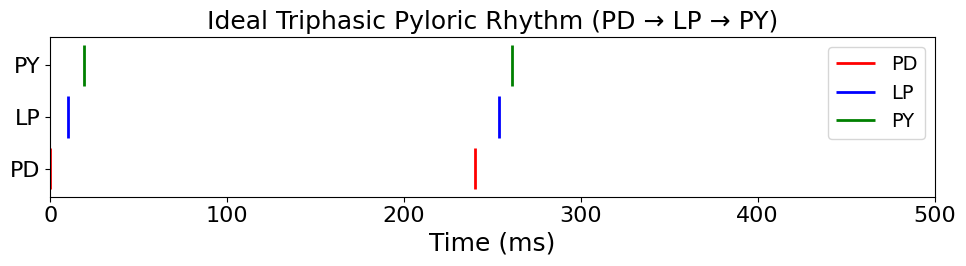

In [7]:
# Step 1: Define & visualize a triphasic pyloric rhythm PD → LP → PY

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Neuron order mapping
nrn_labels = ['AB', 'VD', 'IC', 'PD', 'LP', 'PY']
triphasic_ids = {'PD': 3, 'LP': 4, 'PY': 5}

# Rhythm validator with triphasic sequence logic
def is_valid_triphasic(spikes, min_bursts=3, isi_min=100, isi_max=1000, sequence_gap=20):
    triplet = [triphasic_ids['PD'], triphasic_ids['LP'], triphasic_ids['PY']]

    # Each neuron must have ≥3 spikes and proper ISIs
    for idx in triplet:
        times = np.array(spikes[idx])
        if len(times) < min_bursts:
            return False
        isis = np.diff(times)
        if np.sum((isis > isi_min) & (isis < isi_max)) < min_bursts - 1:
            return False

    # Validate temporal sequence of PD→LP→PY
    pd_spikes = np.array(spikes[triplet[0]])
    lp_spikes = np.array(spikes[triplet[1]])
    py_spikes = np.array(spikes[triplet[2]])

    # For each PD spike, check if LP and PY follow within allowed gap
    sequence_matches = 0
    for t_pd in pd_spikes:
        t_lp = lp_spikes[(lp_spikes > t_pd) & (lp_spikes < t_pd + 200)]
        if len(t_lp) == 0:
            continue
        t_lp = t_lp[0]
        t_py = py_spikes[(py_spikes > t_lp) & (py_spikes < t_lp + sequence_gap)]
        if len(t_py) == 0:
            continue
        sequence_matches += 1

    return sequence_matches >= min_bursts

# Schematic visualization of expected triphasic bursts
def show_triphasic_example(min_bursts=3, isi_range=(200, 300), sequence_gap=20):
    fig, ax = plt.subplots(figsize=(10, 3))
    names = ['PD', 'LP', 'PY']
    offsets = [0, 1, 2]
    for cycle in range(min_bursts):
        t_start = cycle * np.random.randint(*isi_range)
        pd_t = t_start
        lp_t = pd_t + np.random.randint(5, 15)
        py_t = lp_t + np.random.randint(5, sequence_gap)
        ax.vlines([pd_t], offsets[0] - 0.4, offsets[0] + 0.4, label='PD' if cycle == 0 else "", color='red')
        ax.vlines([lp_t], offsets[1] - 0.4, offsets[1] + 0.4, label='LP' if cycle == 0 else "", color='blue')
        ax.vlines([py_t], offsets[2] - 0.4, offsets[2] + 0.4, label='PY' if cycle == 0 else "", color='green')
    ax.set_yticks(offsets)
    ax.set_yticklabels(names)
    ax.set_title("Ideal Triphasic Pyloric Rhythm (PD → LP → PY)")
    ax.set_xlabel("Time (ms)")
    ax.legend()
    ax.set_xlim(0, 500)
    plt.tight_layout()
    plt.show()

# Show expected rhythm visually
show_triphasic_example()


## Step 2: Interactive Degeneracy Search

> **Goal:** Explore how many different synaptic configurations (weight matrices) can give rise to the same pyloric rhythm — a phenomenon known as **degeneracy**.

This cell provides interactive controls for:

- **Number of trials** to simulate (e.g., 100–1000 networks)
- **Ablation of neurons**: choose to disable one or more neurons entirely, simulating biological lesions
- A **"Run Degeneracy Search"** button to begin sampling and testing networks

The simulation process:

1. Randomly samples synaptic weights for the allowable network connections
2. Constructs and runs a simulated network using the `stg_net` package with noisy inputs
3. Evaluates the output using `is_valid_triphasic` to check for rhythm validity
4. Collects all successful weight configurations into a list (`valid_configs`)

This interactive setup lets students explore how robust the pyloric circuit is to perturbations, and test specific hypotheses about neuron function.


In [8]:
# Step 2: UI to configure and run degeneracy trials

import ipywidgets as widgets
from IPython.display import display
from stg_net.neuron import LIF
from stg_net.input import Current_injector
from stg_net.conn import Simulator
from tqdm import tqdm

# --- Configurable widgets ---
trial_slider = widgets.IntSlider(value=100, min=10, max=1000, step=10, description='Trials')
ablate_picker = widgets.SelectMultiple(
    options=nrn_labels,
    description='Ablate:',
    layout=widgets.Layout(height='100px')
)
run_button = widgets.Button(description="Run Degeneracy Search", button_style='success')

display(trial_slider, ablate_picker, run_button)

# --- Fixed network params ---
N = 6
rt = 50.
T, dt = 5e2, 0.1
signs = np.array([
    [ 0 , 1 , 0 , 1 , 0 , 0],
    [-1, 0 , -1, 0 , -1, 0],
    [-1, -1, 0 , -1, 0 , -1],
    [ 1 , 1 , 0 , 0 , -1, 0],
    [-1, -1, 0 , -1, 0 , -1],
    [-1, -1, 0 , -1, -1, 0]
])
valid_indices = [(i, j) for i in range(N) for j in range(N) if signs[i][j] != 0]
neuron_params = {'bursting_neuron': {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}}

# --- Callback ---
valid_configs = []

def on_run_clicked(b):
    global valid_configs
    n_trials = trial_slider.value
    ablate_ids = [nrn_labels.index(n) for n in ablate_picker.value]

    valid_weights = []
    for _ in tqdm(range(n_trials), desc="Sampling networks"):
        weights = np.zeros((N, N))
        for i, j in valid_indices:
            weights[i, j] = np.random.uniform(-5.0, -0.05)

        h = Simulator(dt=dt)
        nrns = [LIF(sim=h) for _ in range(N)]
        for nrn, label in zip(nrns, nrn_labels):
            nrn.name = label
            nrn.update(neuron_params['bursting_neuron'])

        if ablate_ids:
            for idx in ablate_ids:
                weights[idx, :] = 0
                weights[:, idx] = 0

        noises = [Current_injector(sim=h, rate=rt, start=int(T/dt*0.1), end=int(T/dt*0.9)) for _ in range(N)]
        for noise, nrn in zip(noises, nrns):
            nrn.connect(noise, {'ctype': 'Static', 'weight': 1.0})

        types = [['Gap' if signs[i][j] > 0 else 'Static' for j in range(N)] for i in range(N)]
        delays = np.random.uniform(2., 5., (N, N))
        specs = [[{'ctype': types[i][j], 'weight': weights[i, j], 'delay': delays[i, j]} for j in range(N)] for i in range(N)]

        h.connect(nrns, nrns, specs)
        h.run(T)

        spike_trains = [np.array(nrn.spikes['times']) for nrn in nrns]
        if is_valid_triphasic(spike_trains):
            valid_weights.append(weights.copy())

    valid_configs = np.array(valid_weights)
    print(f"✅ Found {len(valid_configs)} valid pyloric circuits.")

# Bind the button
run_button.on_click(on_run_clicked)


IntSlider(value=100, description='Trials', max=1000, min=10, step=10)

SelectMultiple(description='Ablate:', layout=Layout(height='100px'), options=('AB', 'VD', 'IC', 'PD', 'LP', 'P…

Button(button_style='success', description='Run Degeneracy Search', style=ButtonStyle())

Sampling networks: 100%|██████████| 80/80 [01:17<00:00,  1.03it/s]

✅ Found 1 valid pyloric circuits.


## Step 3: Analyze and Visualize Valid Configurations

> **Goal:** Visualize the variability in valid synaptic configurations that produce the same pyloric rhythm, to understand which connections are flexible or tightly constrained.

This cell generates a plot showing:

- **Mean** and **standard deviation** of each synaptic connection’s weight
- Each connection is labeled with biologically relevant neuron names (e.g., `PD→LP`), not index values
- This provides insight into which synaptic pathways are essential for maintaining the pyloric rhythm versus which are more tolerant to change


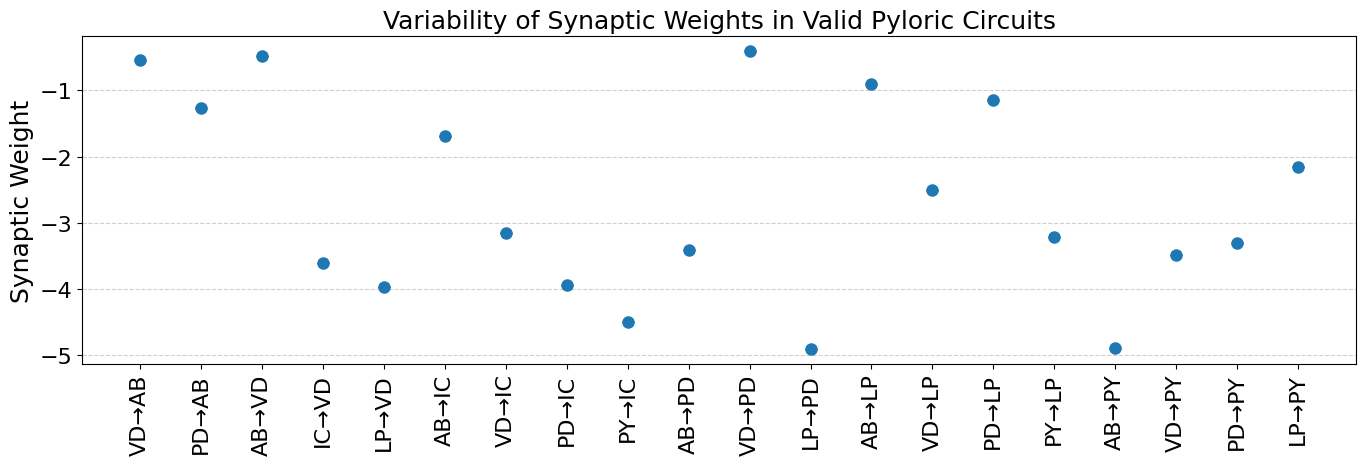

In [9]:
def plot_weight_variability(weight_matrices):
    if len(weight_matrices) == 0:
        print("⚠️ No valid networks found to analyze.")
        return

    syn_vectors = [w[i, j] for w in weight_matrices for (i, j) in valid_indices]
    reshaped = np.array(syn_vectors).reshape(len(weight_matrices), -1)

    means = reshaped.mean(axis=0)
    stds = reshaped.std(axis=0)

    labels = [f"{nrn_labels[j]}→{nrn_labels[i]}" for (i, j) in valid_indices]

    plt.figure(figsize=(14, 5))
    plt.errorbar(range(len(labels)), means, yerr=stds, fmt='o', capsize=4)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.title("Variability of Synaptic Weights in Valid Pyloric Circuits")
    plt.ylabel("Synaptic Weight")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_weight_variability(valid_configs)